# IML - P2

![15560369383553_2c2.jpg](input/15560369383553_2c2.jpg)

1. Select Data

2. Clean up Data

3. Transform Data


# Exploratory Data Analysis

## What's provided ?

### Target

Show representations of the dataset through univariate and multivariate analysis

main interesting feature are:
* nutriscore_score
* nutriscore_grade

### Size / Nb lines & columns

Data set contains 186 columns and approx 2Mio lignes

### Types of features / variables

it contains a mix of types : dates, strings, numbers

Interesting ones:

#### Qualitative
* countries_tags
* allergens
* traces
* additives
* pnns_groups_1 [explanation (fr)](https://solidarites-sante.gouv.fr/IMG/pdf/pnns4_2019-2023.pdf)
* pnns_groups_2
* nova_group [explanation (fr)](https://www.thierrysouccar.com/nutrition/info/nova-une-classification-des-aliments-basee-sur-la-science-3936)
* brand_owner ?
* main_category

#### Quantitative
* serving_size
* serving_quantity
* no_nutriments
* additives_n
* ingredients_from_palm_oil_n
* ingredients_that_may_be_from_palm_oil_n
* nutriscore_score
* nutriscore_grade
* ecoscore_score_fr
* ecoscore_grade_fr

Detailed variables :

* abcd_100g

### Missing values identification

What are the features which have lots of NaN / empty values ?


## What's in it ?

* Target visualisation (hist, boxplot)

* Features comprehension

* Features - target relations

* Outliers recognition

In [1]:
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno

os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

# import pandas as pd
import modin.pandas as pd
import ray
ray.init(ignore_reinit_error=True)

from scipy import stats

> important notice : import is made with date type parsing sepcified for some columns, after preliminary analysis

# LOADING

![](assets/loading.png)


In [2]:
df = pd.read_csv('input/open-food-facts/en.openfoodfacts.org.products.csv', sep='\t', parse_dates=['created_datetime','last_modified_datetime'])

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


In [3]:
df_bck = df.copy()

In [4]:
df = df_bck.copy()

In [5]:
df.shape

(1988476, 186)

In [6]:
# pd.set_option('display.max_columns', None)
df.head()


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16 14:53:28+00:00,1623855209,2021-06-16 14:53:29+00:00,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01 08:11:51+00:00,1630484064,2021-09-01 08:14:24+00:00,L.casei,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15 10:38:00+00:00,1561463718,2019-06-25 11:55:18+00:00,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13 21:06:14+00:00,1539464817,2018-10-13 21:06:57+00:00,Cacao,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19 15:02:16+00:00,1624390765,2021-06-22 19:39:25+00:00,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.describe()

,created_t,last_modified_t,cities,allergens_en,serving_quantity,no_nutriments,additives_n,additives,ingredients_from_palm_oil_n,ingredients_from_palm_oil,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,1.988476e+06,1.988476e+06,0.0,0.0,4.975140e+05,0.0,722441.000000,0.0,722441.000000,0.0,...,11867.000000,719224.000000,8.000000,4.000000,1.0,63.000000,1712.000000,38.000000,69.000000,39.000000
mean,1.560070e+09,1.595301e+09,NaN,NaN,2.233335e+16,NaN,2.029187,NaN,0.020294,NaN,...,615.324945,9.103861,13.875000,34.175000,9100.0,3.238417,0.068921,3.278158,2.201766,0.025676
std,5.296541e+07,3.116836e+07,NaN,NaN,1.575269e+19,NaN,2.899762,NaN,0.142943,NaN,...,6082.140585,8.842205,8.576338,15.620153,NaN,18.705382,1.826776,1.562956,12.669790,0.090002
min,1.328021e+09,1.333873e+09,NaN,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000,NaN,...,0.049000,-15.000000,1.000000,14.000000,9100.0,0.000000,0.000000,0.400000,0.001350,0.000800
25%,1.524120e+09,1.582759e+09,NaN,NaN,2.800000e+01,NaN,0.000000,NaN,0.000000,NaN,...,107.800000,1.000000,8.250000,26.000000,9100.0,0.056500,0.000008,2.450000,0.010000,0.007050
50%,1.571243e+09,1.599393e+09,NaN,NaN,5.300000e+01,NaN,1.000000,NaN,0.000000,NaN,...,328.500000,10.000000,15.500000,37.000000,9100.0,0.073600,0.000023,3.600000,0.025000,0.011000
75%,1.603225e+09,1.619531e+09,NaN,NaN,1.133981e+02,NaN,3.000000,NaN,0.000000,NaN,...,614.200000,16.000000,22.000000,45.175000,9100.0,0.125000,0.000096,4.000000,0.047000,0.015000
max,1.634172e+09,1.634172e+09,NaN,NaN,1.111111e+22,NaN,49.000000,NaN,3.000000,NaN,...,656298.600000,40.000000,22.000000,48.700000,9100.0,136.000000,54.000000,7.300000,75.000000,0.572000


In [8]:
df.columns.size

186

# CLEANING

![](assets/data_cleaning.jpeg)


## Features Types

In [9]:
for col in range(0, df.columns.size):
    print(f'{df.columns[col]:<45} {str(df.dtypes[col]):>}')

code                                          object
url                                           object
creator                                       object
created_t                                     int64
created_datetime                              datetime64[ns, UTC]
last_modified_t                               int64
last_modified_datetime                        datetime64[ns, UTC]
product_name                                  object
abbreviated_product_name                      object
generic_name                                  object
quantity                                      object
packaging                                     object
packaging_tags                                object
packaging_text                                object
brands                                        object
brands_tags                                   object
categories                                    object
categories_tags                               object
categories_en         

<AxesSubplot:ylabel='None'>

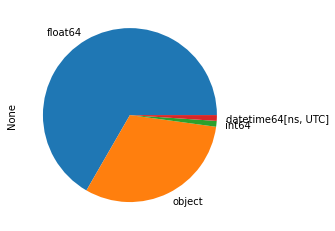

In [10]:
df.dtypes.value_counts().plot.pie()

## Investigate `int` and `date` values

In [11]:
df.columns[((df.dtypes != 'float') & (df.dtypes != 'object'))]

Index(['created_t', 'created_datetime', 'last_modified_t',
       'last_modified_datetime'],
      dtype='object')

In [12]:
df.dtypes[['created_t','created_datetime','last_modified_t', 'last_modified_datetime']]

created_t                               int64
created_datetime          datetime64[ns, UTC]
last_modified_t                         int64
last_modified_datetime    datetime64[ns, UTC]
dtype: object

In [13]:
df[['created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime']]

,created_t,created_datetime,last_modified_t,last_modified_datetime
0,1623855208,2021-06-16 14:53:28+00:00,1623855209,2021-06-16 14:53:29+00:00
1,1630483911,2021-09-01 08:11:51+00:00,1630484064,2021-09-01 08:14:24+00:00
2,1529059080,2018-06-15 10:38:00+00:00,1561463718,2019-06-25 11:55:18+00:00
3,1539464774,2018-10-13 21:06:14+00:00,1539464817,2018-10-13 21:06:57+00:00
4,1574175736,2019-11-19 15:02:16+00:00,1624390765,2021-06-22 19:39:25+00:00
...,...,...,...,...
1988471,1572513866,2019-10-31 09:24:26+00:00,1572513866,2019-10-31 09:24:26+00:00
1988472,1608105503,2020-12-16 07:58:23+00:00,1608105504,2020-12-16 07:58:24+00:00
1988473,1581171613,2020-02-08 14:20:13+00:00,1582644247,2020-02-25 15:24:07+00:00
1988474,1613129728,2021-02-12 11:35:28+00:00,1613129730,2021-02-12 11:35:30+00:00


In [14]:
pd.to_datetime(df['created_t'], unit='s').head()

0   2021-06-16 14:53:28
1   2021-09-01 08:11:51
2   2018-06-15 10:38:00
3   2018-10-13 21:06:14
4   2019-11-19 15:02:16
Name: created_t, dtype: datetime64[ns]

we can see `created_t` and `created_datetime` represents the same but in different format. We choose to keep only one

In [15]:
df.drop({
    'created_t', 
    'last_modified_t', 
        }, axis=1, inplace=True)

## Cleaning unecessary data


### Remove empty columns 

let's compute the ratio: $ \frac{\text{empty values}}{\text{nb rows}} $

In [16]:
pd.set_option('display.max_rows', None)

To request implementation, send an email to feature_requests@modin.org.


<AxesSubplot:ylabel='Frequency'>

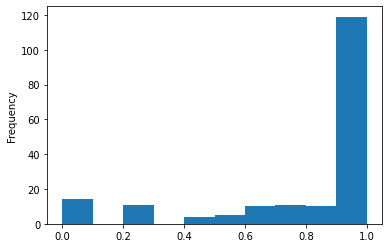

In [17]:
df.sample(round(df.shape[0]*0.02)).isna().mean().sort_values().plot(kind="hist")

About 120 out of 186 columns have more than 80% of empty cells. The dataset despite being large, is almost empty !

(apply_list_of_funcs pid=568760) 


<AxesSubplot:>

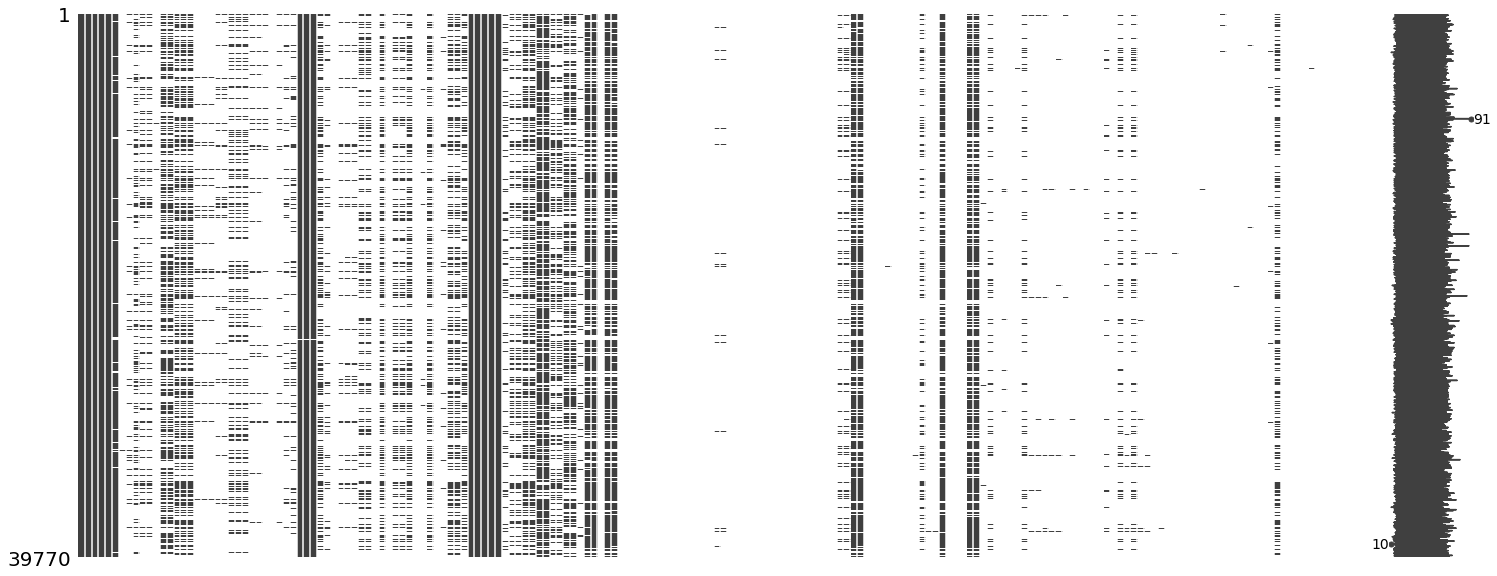

In [18]:
msno.matrix(df.sample(round(df.shape[0]*0.02)))

Taking a sample (20%) of the dataset, to ease compute, we can see there are some plateau of columns missing data, let's consider we want to remove at least those that have more than 70% of missing value.

In [19]:
threshold = 0.7
df = df[df.columns[df.isna().mean() < threshold]]

(apply_func pid=568784) 


### Remove not interesting columns

List remaining columns, remove the obviouses manually

#### Remove 'url' features


In [20]:
url_columns = df.filter(regex='url').columns.values
print(url_columns)
df = df.drop(url_columns, axis=1)

['url' 'image_url' 'image_small_url' 'image_ingredients_url'
 'image_ingredients_small_url' 'image_nutrition_url'
 'image_nutrition_small_url']


<AxesSubplot:ylabel='None'>

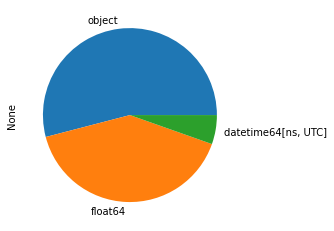

In [21]:
df.dtypes.value_counts().plot.pie()

<AxesSubplot:ylabel='Frequency'>

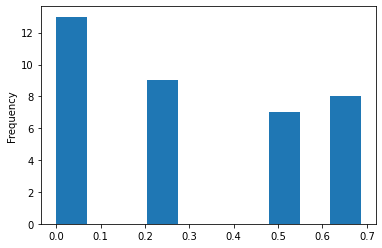

In [22]:
df.sample(round(df.shape[0]*0.02)).isna().mean().sort_values().plot(kind="hist")

<AxesSubplot:>

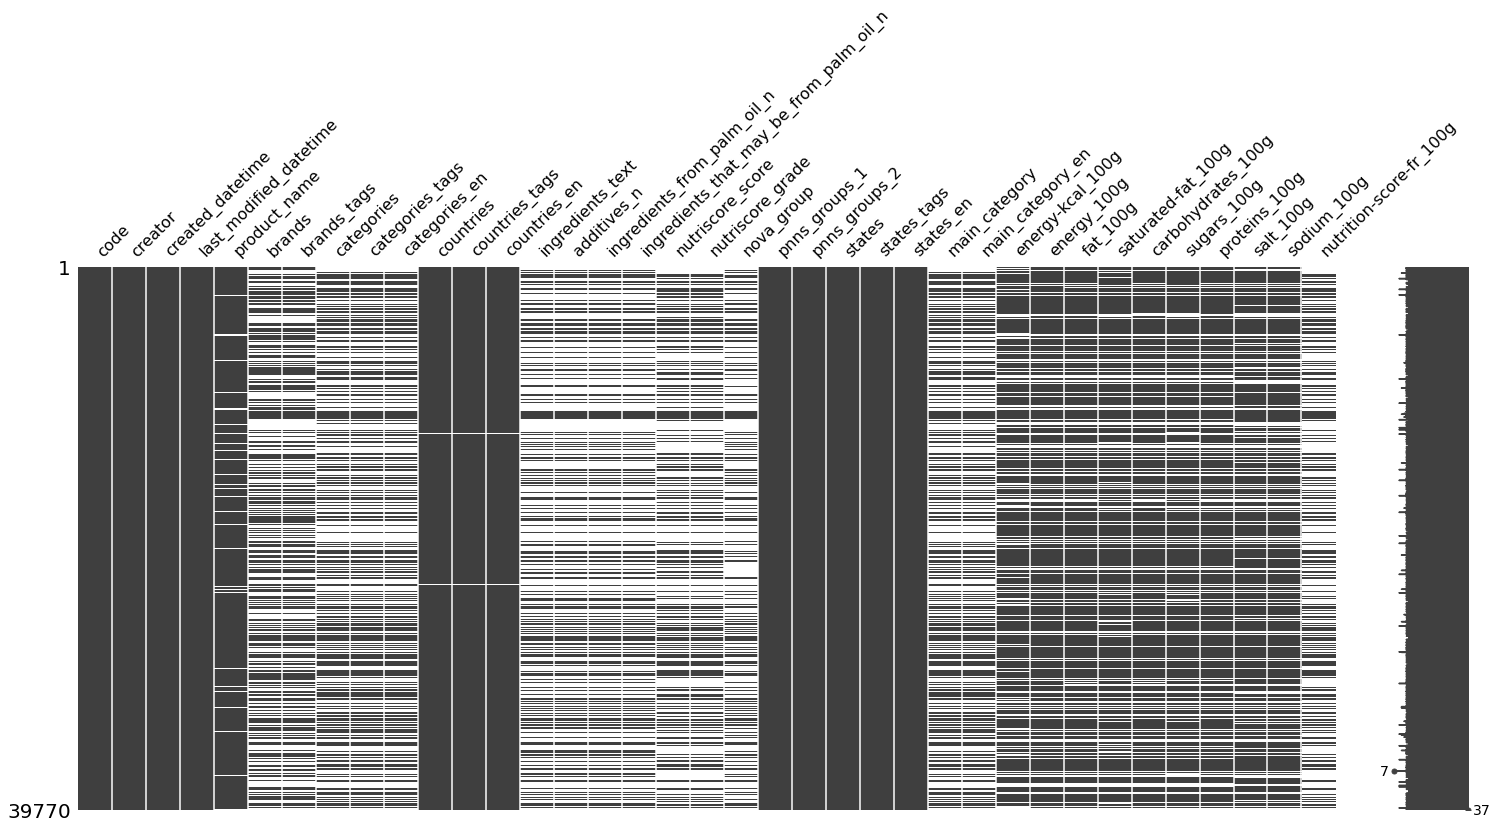

In [23]:
msno.matrix(df.sample(round(df.shape[0]*0.02)))

In [24]:
df.columns.size

37

## Conclusion

Now we have a dataset with 37 remaining columns, which have at least 70% of data filled in each. 

Only 3 kind of types exists.

We can start analysing the values, in a consistent way


# ANALYSIS

![](assets/SEO-analysis.jpg)

## Outliers analysis

In [25]:
for col in df.select_dtypes('float').columns:
    print(col)

additives_n
ingredients_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_n
nutriscore_score
nova_group
energy-kcal_100g
energy_100g
fat_100g
saturated-fat_100g
carbohydrates_100g
sugars_100g
proteins_100g
salt_100g
sodium_100g
nutrition-score-fr_100g


In [26]:
pd.options.display.float_format = '{:.2f}'.format
df.select_dtypes('float').agg(["min", "max", "median", "mean", "var", "std", "skew", "kurtosis"]).T

(apply_list_of_funcs pid=568760) 


,min,max,median,mean,var,std,skew,kurtosis
additives_n,0.00,49.00,1.00,2.03,8.41,2.90,2.38,8.47
ingredients_from_palm_oil_n,0.00,3.00,0.00,0.02,0.02,0.14,7.09,50.82
ingredients_that_may_be_from_palm_oil_n,0.00,6.00,0.00,0.07,0.09,0.30,5.36,36.94
nutriscore_score,-15.00,40.00,10.00,9.10,78.18,8.84,0.10,-0.94
nova_group,1.00,4.00,4.00,3.42,0.95,0.97,-1.65,1.43
energy-kcal_100g,0.00,100000000376832.00,260.00,71277250.65,6601771003401592635392.00,81251283087.72,1222.32,1503466.53
energy_100g,0.00,6665558888888888950360610417759390841962496.00,1079.00,4225230522869726631061498661649252352.00,28163522869318955277429537580043184023559817948...,5306931587020785931728607601085372170240.00,1256.01,1577561.00
fat_100g,0.00,110000001253376.00,7.00,70079644.28,7708759428570484310016.00,87799541163.78,1252.85,1569643.00
saturated-fat_100g,0.00,16700.00,1.80,5.10,274.25,16.56,682.82,678025.81
carbohydrates_100g,-1.00,762939.00,15.10,28.86,400567.09,632.90,1135.27,1350921.00


In [27]:
# df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
# df_zscore = (df['energy_100g'] - df['energy_100g'].mean())/df['energy_100g'].std()

In [28]:
# df_bck[df_bck['energy_100g'] == df_bck['energy_100g'].max()].T

<function matplotlib.pyplot.show(close=None, block=None)>

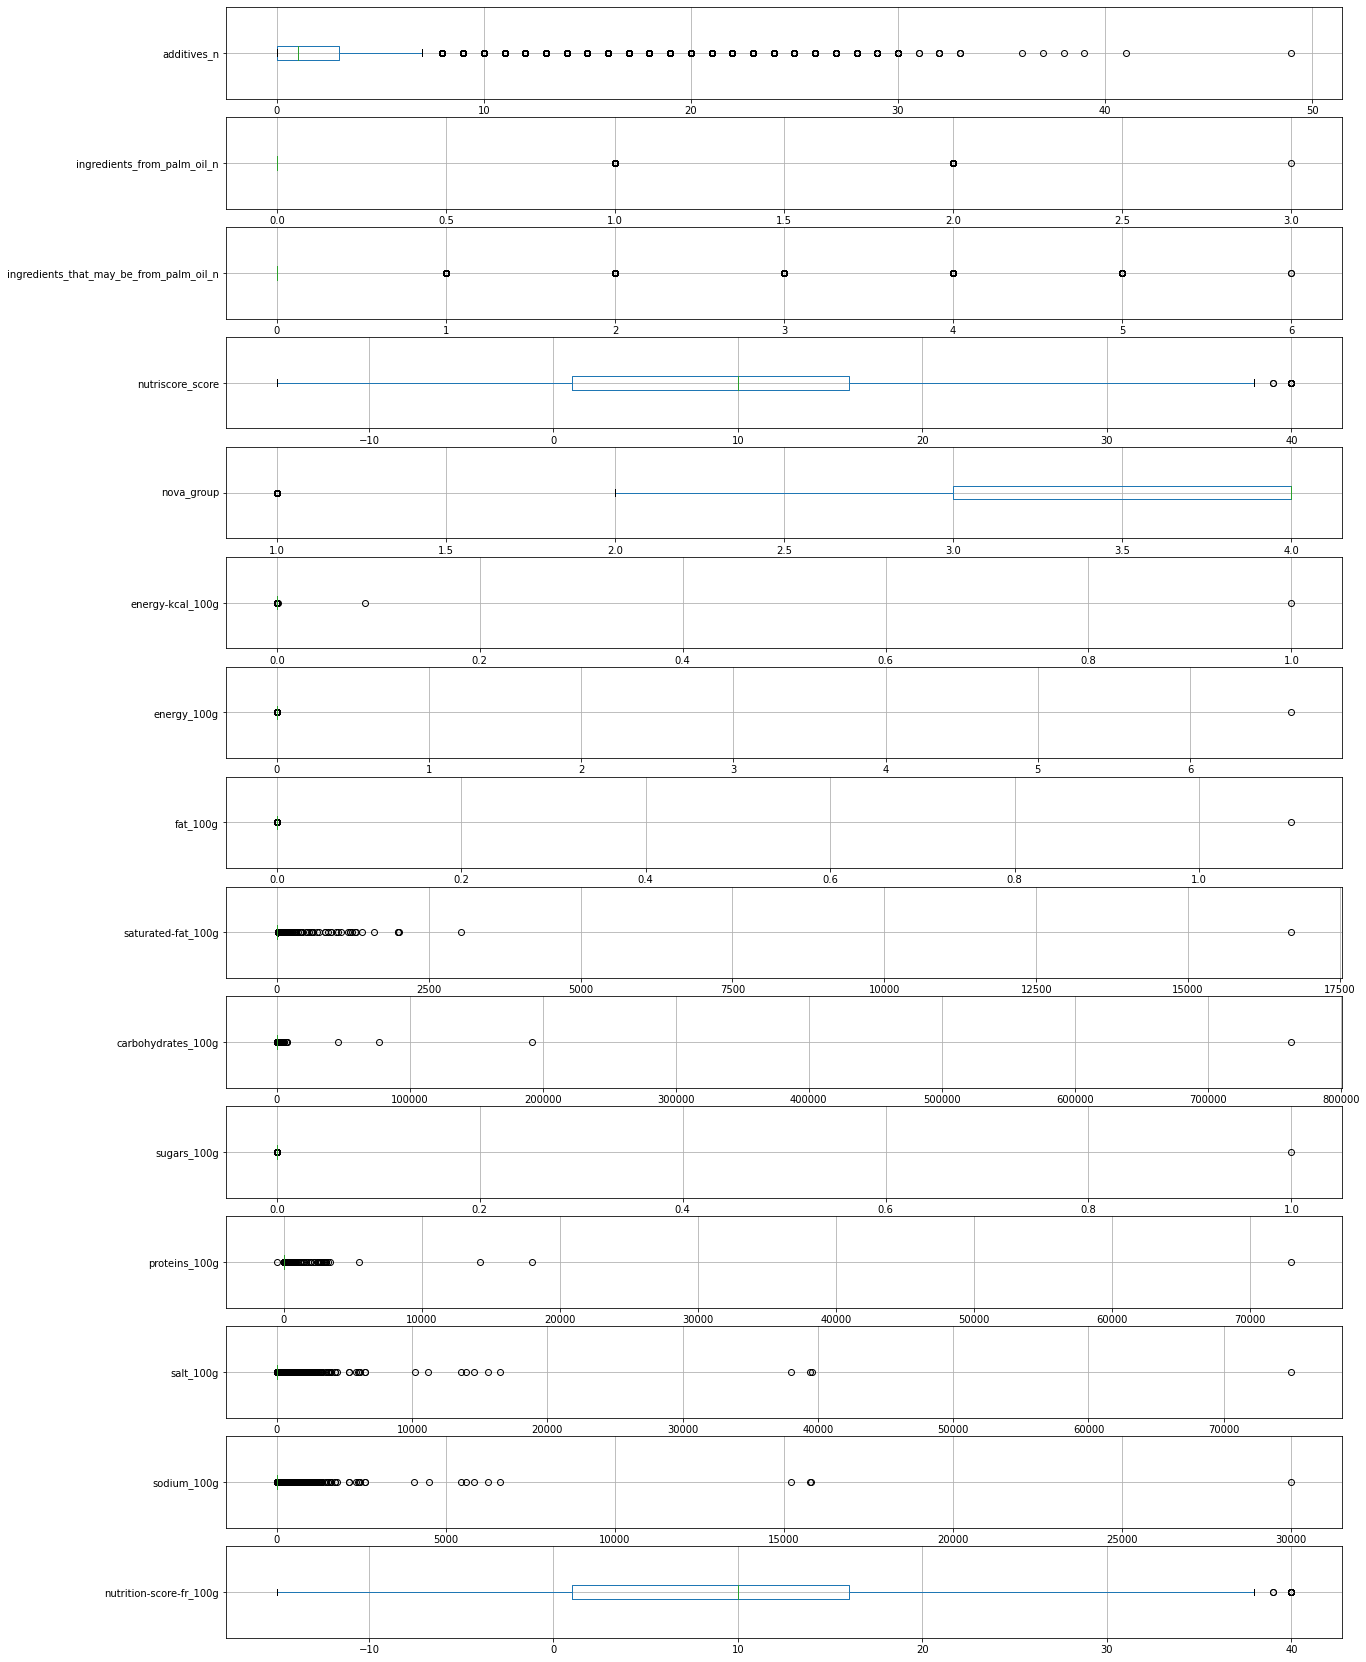

In [29]:
size = df.select_dtypes('float').columns.size
plt.figure(figsize=(20,30))
for i, col in enumerate(df.select_dtypes('float')):
    plt.subplot(size, 1, i+1)
    df.boxplot(column=col, vert=False)
plt.show

We see that:

| Feature | Comment |
|:-----|:-----|
| additives_n | lots of outliers above 8 |
| ingredients_from_palm_oil_n | just fex values (1, 2, 3) |
| ingredients_that_may_be_from_palm_oil_n | just few values (1, 2, 3, 4, 5, 6) |
| nutriscore_score | distribution to investigate |
| nova_group | distribution to investigate |
| energy-kcal_100g | two outliers above 0.1 |
| energy_100g | one outlier above 6 |
| fat_100g | one outlier above 1 |
| saturated-fat_100g | lots of outliers, need to refine |
| carbohydrates_100g | outliers above ~50000 |
| sugars_100g | one outlier above 0.1 |
| proteins_100g | lots of outliers above 5000 |
| salt_100g | lots of outliers above 2000 |
| sodium_100g | lots of outliers above ~2500 |
| nutrition-score-fr_100g | distribution to investigate |


<function matplotlib.pyplot.show(close=None, block=None)>

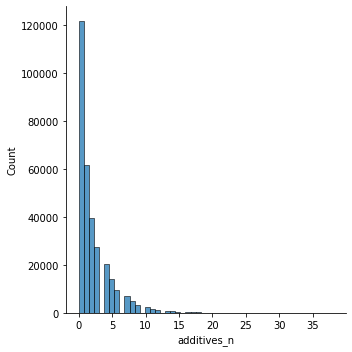

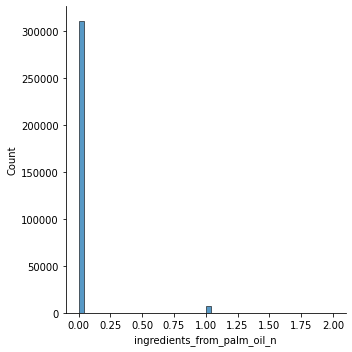

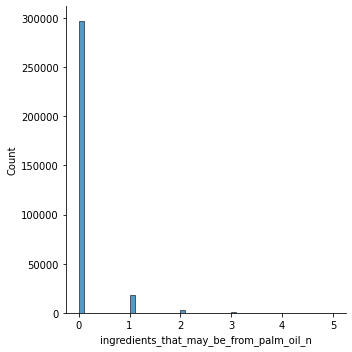

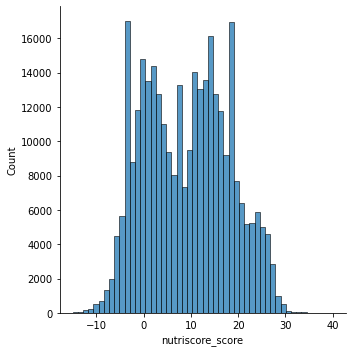

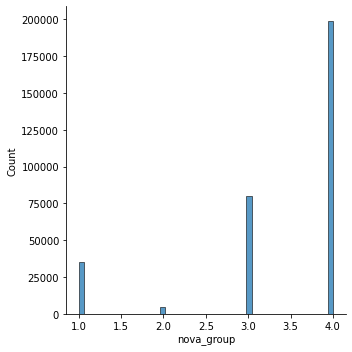

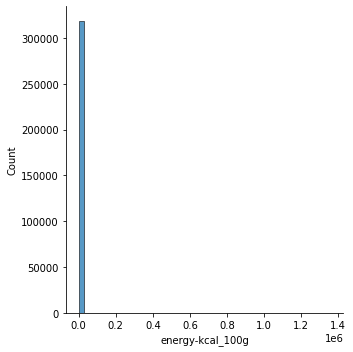

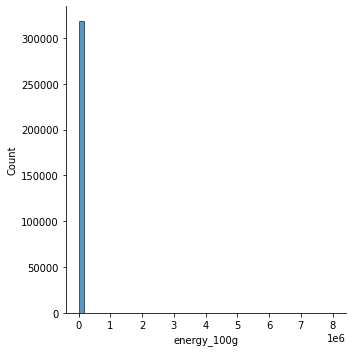

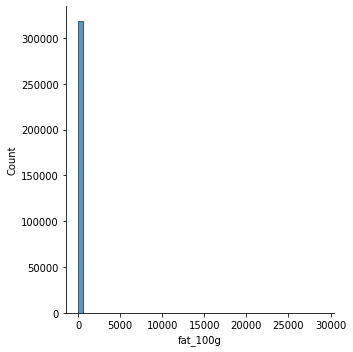

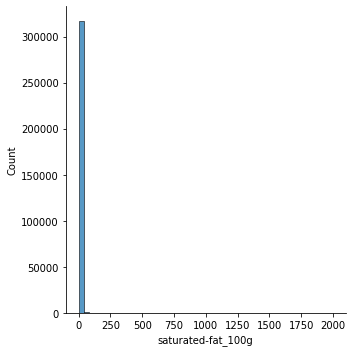

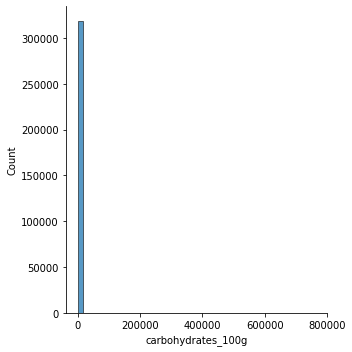

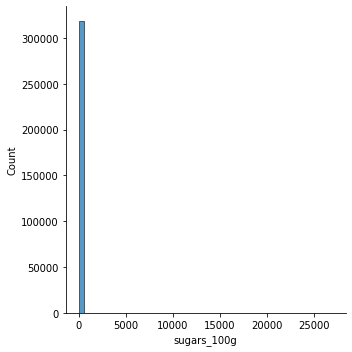

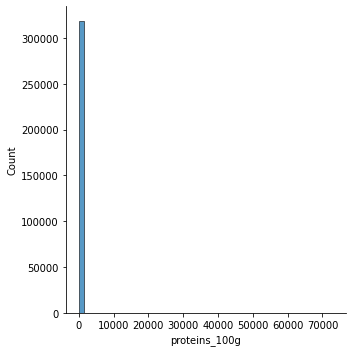

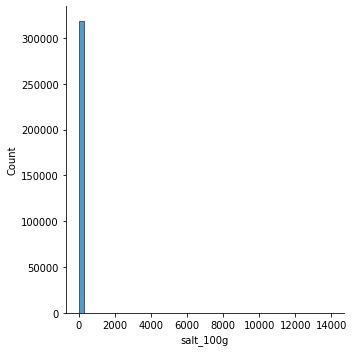

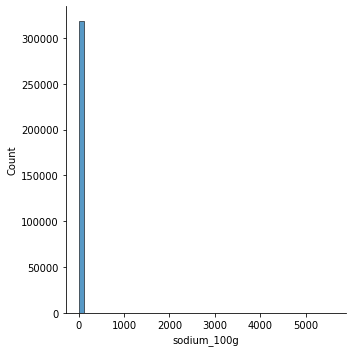

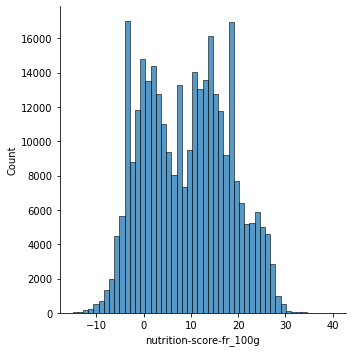

In [30]:
tmp_df = df.dropna()
size = tmp_df.select_dtypes('float').columns.size
for i, col in enumerate(df.select_dtypes('float')):
    sns.displot(tmp_df, x=col, bins=50)
plt.show

In [31]:
# df.loc[:, 'energy-kcal_100g'].isnull()
for i, col in enumerate(df.select_dtypes('float')):
    print(f"{(df.loc[:,col].fillna(float(0)) == 0).mean()}")

additives_n   0.79
dtype: float64
ingredients_from_palm_oil_n   0.99
dtype: float64
ingredients_that_may_be_from_palm_oil_n   0.98
dtype: float64
nutriscore_score   0.66
dtype: float64
nova_group   0.68
dtype: float64
energy-kcal_100g   0.25
dtype: float64
energy_100g   0.23
dtype: float64
fat_100g   0.33
dtype: float64
saturated-fat_100g   0.40
dtype: float64
carbohydrates_100g   0.27
dtype: float64
sugars_100g   0.34
dtype: float64
proteins_100g   0.31
dtype: float64
salt_100g   0.37
dtype: float64
sodium_100g   0.37
dtype: float64
nutrition-score-fr_100g   0.66
dtype: float64


Correlation btw 'nutriscore_score' and 'additives_n'

'contingency table'


In [32]:
pd.crosstab(df['nutriscore_score'], df['additives_n'], dropna=True )

col_0,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,...,27.00,28.00,29.00,30.00,31.00,32.00,33.00,36.00,38.00,39.00
row_0,,,,,,,,,,,,,,,,,,,,,
-15.00,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-14.00,65,5,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-13.00,149,2,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-12.00,253,7,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-11.00,330,15,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-10.00,756,67,24,8,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
-9.00,1082,70,30,12,5,1,5,0,0,1,...,0,0,0,0,0,0,0,0,0,0
-8.00,2180,195,34,14,10,9,3,3,2,1,...,0,0,0,0,0,0,0,0,0,0
-7.00,3090,280,79,39,19,7,7,6,8,2,...,0,0,0,0,0,0,0,0,0,0


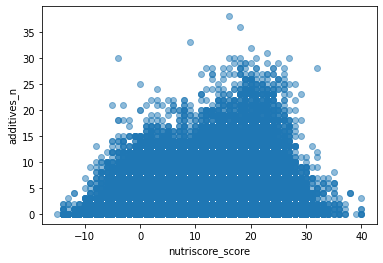

In [33]:
tmp_df = df.dropna()
plt.scatter(tmp_df['nutriscore_score'], tmp_df['additives_n'], alpha=0.5)
plt.xlabel('nutriscore_score')
plt.ylabel('additives_n')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

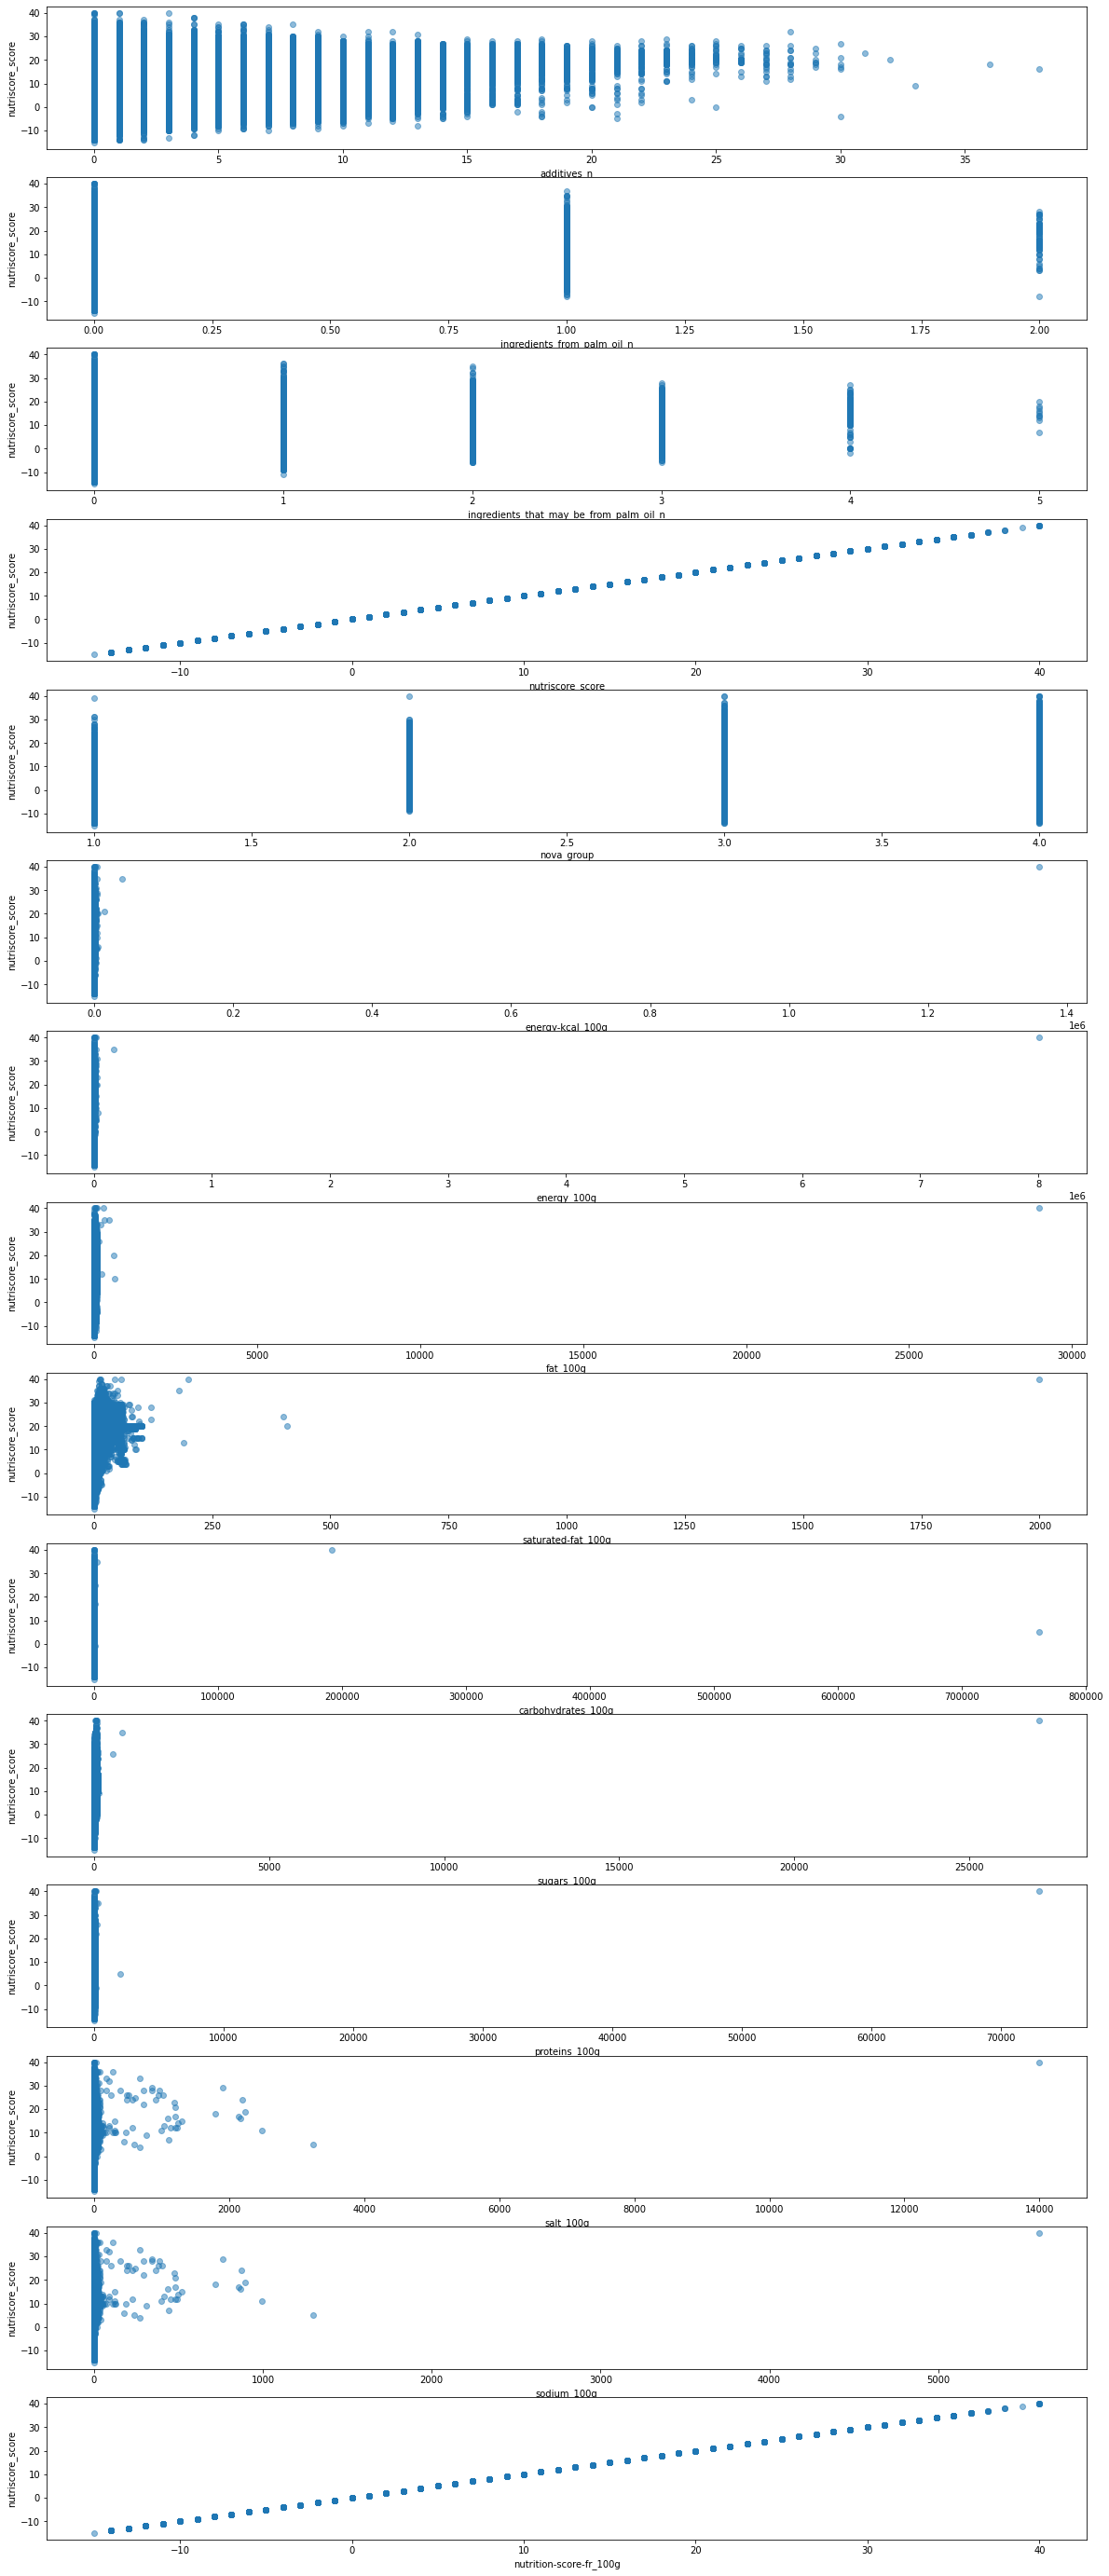

In [34]:
tmp_df = df.dropna()
plt.figure(figsize=(20,50))
size = tmp_df.select_dtypes('float').columns.size
for i, col in enumerate(df.select_dtypes('float')):
    plt.subplot(size, 1, i+1)
    plt.scatter(tmp_df[col], tmp_df['nutriscore_score'], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('nutriscore_score')
plt.show

This feature has a multi modal distribution

## Qualitative Values

With a pre-filtered dataset. 

Let's look at the qualitative values, which ones are of interest


### dispertion of values

Let's show object features with their unique values : we are looking for features that contains just a few values, otherwise this is not interesting

In [35]:
df.columns[df.dtypes == 'object']

Index(['code', 'creator', 'product_name', 'brands', 'brands_tags',
       'categories', 'categories_tags', 'categories_en', 'countries',
       'countries_tags', 'countries_en', 'ingredients_text',
       'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'states',
       'states_tags', 'states_en', 'main_category', 'main_category_en'],
      dtype='object')

In [36]:
df['categories'].mode()

0    Snacks
Name: categories, dtype: object

In [37]:
df['countries_tags'].mode()

0    en:france
Name: countries_tags, dtype: object

We remove the columns with a higher percentage of not unique values, because they will result in a too big variance

So, we should only keep:

countries_en, additives_tags, nutriscore_grade, pnns_groups_1,pnns_groups_2,ecoscore_grade_fr,

## Quantitative Values

### Empirical Variance (Variance Empirique)

$ \upsilon = \frac{1}{n} \sum_{i=1}^n(x_i - \bar{x})²$

### Standard Deviation (Ecart-Type Empirique)

$ s = \sqrt{\upsilon} $ 


In [38]:
for col in df.select_dtypes('object'):
    print(f'{col} {(df[col].unique().size / df[col].size):.0%}')

code 100%
creator 1%
product_name 62%
brands 9%
brands_tags 7%
categories 6%
categories_tags 4%
categories_en 4%
countries 1%
countries_tags 0%
countries_en 0%
ingredients_text 31%
nutriscore_grade 0%
pnns_groups_1 0%
pnns_groups_2 0%
states 0%
states_tags 0%
states_en 0%
main_category 2%
main_category_en 2%


In [51]:
pd.crosstab(df['categories'], df['nutriscore_grade'])
# sns.catplot(x='categories', y='nutriscore_grade', data=df)

col_0,a,b,c,d,e
row_0,,,,,
% de matières grasses,0,2,0,1,0
0,0,3,1,0,0
05 PP,1,0,0,0,0
1,2,1,2,0,0
1% Low Fat Milk with Added Milk Protein,1,0,0,0,0
10,0,1,1,0,0
100,0,0,0,0,1
100 per 175g,1,0,0,0,0
100% kokosnootwater,1,0,0,0,0


In [74]:
tmp_df = df.loc[:,'countries'].fillna("")
tmp_df2 = tmp_df.loc[tmp_df['countries'].str.contains("France", case=False)]
tmp_df2

,countries
0,en:france
2,France
3,France
6,France
7,en:France
8,France
9,France
10,France
11,en:france
12,France


In [61]:
pd.crosstab(df['countries'], df['nutriscore_grade'])


col_0,a,b,c,d,e
row_0,,,,,
"Afganistán,Francia,Alemania,España",0,0,0,0,1
"Afganistán,Francia,España",0,1,0,0,0
"Afghanistan,Belgique,France",0,0,0,0,1
"Afghanistan,France",2,3,5,3,1
"Afghanistan,France,Réunion",0,0,1,0,0
"Afghanistan,Frankreich,Deutschland",0,0,0,0,1
Afrique du Sud,6,1,5,2,8
"Afrique du Sud, Swaziland",0,1,0,0,1
"Afrique du Sud, en:india",0,0,0,1,0


In [ ]:
pd.options.display.float_format = '{:.2f}'.format
df.select_dtypes('object').agg(["min", "max", "median", "mean", "var", "std", "skew", "kurtosis"]).T

## Resulting Dataset

We can see that some columns still have lots of empty values, but also that several rows have almost (or all) the features provided,
which is good for further analysis

In [ ]:
# show heatmap : commented out since uses lots of resources, replaced by missingno
# plt.figure(figsize=(20,10))
# sns.heatmap(df.isna(), cbar=False)

# TODO

continuer à nettoyer le dataset

### 1. formater les categories en lowercase, splitter les tags (one hot ?)

tip : `.apply(fct)` existe en python, ex: `data['taille'] = data['taille'].apply(convert_height)`

### 2. analyser les outliers

### 3. approffondir la distribution des quali et quanti [cours](https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4742171-representez-la-distribution-empirique-dune-variable) 

### 4. discretiser les variables continues

> Le fait d'agréger une variable s'appelle la discrétisation (en anglais : binning, bucketing ou discretization).

empirical cumulative distribution function ([ecdf](https://machinelearningmastery.com/empirical-distribution-function-in-python/)) Dans le cas d'une variable qui ne suit pas une loi normale => est-ce le cas dans ce dataset ?

$ F_{emp}(x)=\frac{1}{n}\sum_{i=1}^{n}I_{\{{x_{i}} \leq x\}}$ 

où I est la fonction indicatrice. 1 si xi <= x, 0 sinon
    
code samples from course: 

```python
import matplotlib.pyplot as plt

# VARIABLE QUALITATIVE
# Diagramme en secteurs
data["categ"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

# Diagramme en tuyaux d'orgues
data["categ"].value_counts(normalize=True).plot(kind='bar')
plt.show()

# VARIABLE QUANTITATIVE
# Diagramme en bâtons
data["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

# Histogramme
data["montant"].hist(density=True)
plt.show()
# Histogramme plus beau
data[data.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()
```

### 5. faire le nombre et la fréquence des valeurs quali (pour toutes celles retenues dans le dataset)

```python
effectifs = data["quart_mois"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

tab = pd.DataFrame(modalites, columns = ["quart_mois"]) # création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["f"] = tab["n"] / len(data) # len(data) renvoie la taille de l'échantillon
```

> modalité
>
> effectif
>
> fréquence
>
> variable qualitative ordinale

### 6. reverifier si la suppression des colonnes à du sens, si ce n'est pas preferable pour certaines de remplir avec une valeur arbitraire (moyenne, autre ...)

### 7. remplacer valeur NaN (`fillna`)

### 8. resample dataset ?
pour diminuer la taille et faciliter les calculs ?  `sklearn.utils.resample`

### 9. Analyse ANOVA

correlation entre variables



## Analysis

In [ ]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_1'] )

In [ ]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_2'] )

In [ ]:
plt.figure(figsize=(20,20))
# sns.displot(df, x='nutriscore_grade')
sns.displot(df, x='nutriscore_score', hue='nutriscore_grade', kind='ecdf')
plt.savefig("nutriscore_grade_multivariate_analysis.png", format='png', dpi=150)
sns.displot(df, x='nutriscore_score', y='ecoscore_score_fr', hue='nutriscore_grade')
# sns.displot(df, x='nutriscore_score', y= 'nova_group', hue='nutriscore_grade', kind='kde')
# sns.displot(df, x='nutriscore_score', col='nutriscore_grade')
plt.savefig("nutriscore_ecoscore_multivariate_analysis.png", format='png', dpi=150)

In [ ]:
df['nutriscore_grade'].value_counts(normalize=True).plot.pie()

In [ ]:
df['nutriscore_score'].dropna().value_counts().sort_values(ascending=False)


We can see that some columns still have lots of empty values, but also that several rows have almost (or all) the features provided,
which is good for further analysis



In [ ]:
# most filled features
df.columns[[0, 1, 11, 12, 13, 25, 26, 27, 28, 29]]

In [ ]:
df.columns.get_loc('nutriscore_grade')

2021-11-04 22:28:34,538	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,541	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,544	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,548	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,552	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,554	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,558	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,561	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,564	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,566	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,569	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3

2021-11-04 22:28:34,571	ERROR worker.py:79 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::deploy_ray_func() (pid=568773, ip=192.168.0.23)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/ray/pandas_on_ray/frame/axis_partition.py", line 207, in deploy_ray_func
    result = func(*args)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/axis_partition.py", line 303, in deploy_axis_func
    result = func(dataframe, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/engines/base/frame/data.py", line 1153, in _map_reduce_func
    series_result = func(df, *args, **kwargs)
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/modin/backends/pandas/query_compiler.py", line 2448, in <lambda>
    lambda df: pandas.DataFrame(df.apply(func, axis, *args, **kwargs)),
  File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3